# Copyright Netherlands eScience Center <br>
** Function     : Mask of regionalization of seas in the Arctic from ERA-Interim** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.05.19 ** <br>
** Last Update  : 2019.05.21 ** <br>
Description     : This notebook aims to make the mask file for the regionalization of the seas in the Arctic based on SIC fields from ERA-Interim.<br>
Return Values   : netCDF4 <br>
Caveat          : <br>
The regionalization adopted here follows that of the MASIE (Multisensor Analyzed Sea Ice Extent) product available from the National Snow and Ice Data Center:<br>
https://nsidc.org/data/masie/browse_regions<br>
It is given by paper J.Walsh et. al., 2019. Benchmark seasonal prediction skill estimates based on regional indices.<br>

In [1]:
import numpy as np
import scipy as sp
import time as tttt
from netCDF4 import Dataset,num2date
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import iris
import iris.plot as iplt
import cartopy
import cartopy.crs as ccrs

In [2]:
################################   Input zone  #########################################
# specify starting and ending time
# specify data path
# ERAI 3D fields on pressure level
datapath = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/ERA-Interim/sic_daily'
# specify output path for figures
output_path = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/ERA-Interim/seas_mask'
########################################################################################

In [3]:
print ('*********************** extract variables *************************')
datapath_full = os.path.join(datapath, 'era1991','pressure_daily_075_diagnostic_1991_2_sic.nc')
# get the variable keys
var_key = Dataset(datapath_full)

*********************** extract variables *************************


In [4]:
print ('*********************** basic dimensions and land-sea mask *************************')
sic_grid = var_key.variables['siconc'][0,:,:]
mask = np.ma.getmask(sic_grid[:])
#sic_subdaily[mask==True] = -1.0
latitude = var_key.variables['latitude'][:]
longitude = var_key.variables['longitude'][:]

*********************** basic dimensions and land-sea mask *************************


In [101]:
print ('*********************** create mask *************************')
# W:-156 E:-124 N:80 S:67
mask_Beaufort = np.zeros((len(latitude),len(longitude)),dtype=int)
# W:-180 E:-156 N:80 S:66
mask_Chukchi = np.zeros((len(latitude),len(longitude)),dtype=int)
# W:146 E:180 N:80 S:67
mask_EastSiberian = np.zeros((len(latitude),len(longitude)),dtype=int)
# W:100 E:146 N:80 S:67
mask_Laptev = np.zeros((len(latitude),len(longitude)),dtype=int)
# W:60 E:100 N:80 S:67
mask_Kara = np.zeros((len(latitude),len(longitude)),dtype=int)
# W:18 E:60 N:80 S:64
mask_Barents = np.zeros((len(latitude),len(longitude)),dtype=int)
# W:-44 E:18 N:80 S:55
mask_Greenland = np.zeros((len(latitude),len(longitude)),dtype=int)
# W:-180 E:180 N:90 S:80
mask_CenArctic = np.zeros((len(latitude),len(longitude)),dtype=int)

*********************** create mask *************************


In [100]:
print(longitude[240:264])#
print(latitude[26:47])

[ 0.    0.75  1.5   2.25  3.    3.75  4.5   5.25  6.    6.75  7.5   8.25
  9.    9.75 10.5  11.25 12.   12.75 13.5  14.25 15.   15.75 16.5  17.25]
[70.   69.25 68.5  67.75 67.   66.25 65.5  64.75 64.   63.25 62.5  61.75
 61.   60.25 59.5  58.75 58.   57.25 56.5  55.75 55.  ]


In [102]:
print ('*********************** calc mask *************************')
mask_Beaufort[13:31,32:76] = 1

mask_Chukchi[13:32,0:32] = 1
mask_Chukchi[13:32,-1] = 1

mask_EastSiberian[13:31,434:479] = 1

mask_Laptev[13:31,374:434] = 1

mask_Kara[13:31,320:374] = 1

mask_Barents[13:36,264:320] = 1

mask_Greenland[13:47,179:264] = 1
mask_Greenland[26:47,240:264] = 0

mask_CenArctic[:13,:] = 1

*********************** calc mask *************************


*********************** map view *************************


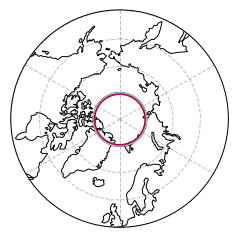

In [104]:
print ('*********************** map view *************************')
# first construct iris coordinate
lat_iris = iris.coords.DimCoord(latitude, standard_name='latitude', long_name='latitude',
                                var_name='lat', units='degrees')
lon_iris = iris.coords.DimCoord(longitude, standard_name='longitude', long_name='longitude',
                                var_name='lon', units='degrees')
coord_sys = iris.coord_systems.GeogCS(iris.fileformats.pp.EARTH_RADIUS)
# assembly the cube
cube_iris = iris.cube.Cube(mask_CenArctic, long_name='geographical field', var_name='field', 
                           units='1', dim_coords_and_dims=[(lat_iris, 0), (lon_iris, 1)])

fig = plt.figure()
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180,180,50,90],ccrs.PlateCarree())
ax.set_aspect('1')
ax.coastlines()
gl = ax.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.ylocator = mticker.FixedLocator([50,60,70,80,90])
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
cs = iplt.contour(cube_iris, cmap='coolwarm') #, vmin=ticks[0], vmax=ticks[-1]
#cbar = fig.colorbar(cs,extend='both', orientation='horizontal',
#                    shrink =0.8, pad=0.05)
iplt.show()
fig.savefig(os.path.join(output_path,'mask_.png'), dpi=300)
plt.close(fig)

In [105]:
#save output datasets
# we only pack our timeseries from 1979 to 2016
def create_netcdf_point (mask_Beaufort, mask_Chukchi, mask_EastSiberian, mask_Laptev,
                         mask_Kara, mask_Barents, mask_Greenland, mask_CenArctic,
                         latitude, longitude, output_path):
    print ('*******************************************************************')
    print ('*********************** create netcdf file*************************')
    print ('*******************************************************************')
    print("Start creating netcdf file for SIV from 1979 to 2017.")
    # wrap the datasets into netcdf file
    # 'NETCDF3_CLASSIC', 'NETCDF3_64BIT', 'NETCDF4_CLASSIC', and 'NETCDF4'
    data_wrap = Dataset(output_path + os.sep + 'sea_Arctic_mask_erai_1979_2017.nc','w',format = 'NETCDF4')
    # create dimensions for netcdf data
    lat_wrap_dim = data_wrap.createDimension('latitude', len(latitude))
    lon_wrap_dim = data_wrap.createDimension('longitude', len(longitude))
    # create coordinate variables for 3-dimensions
    lat_wrap_var = data_wrap.createVariable('latitude',np.float32,('latitude',))
    lon_wrap_var = data_wrap.createVariable('longitude',np.float32,('longitude',))    
    # create the actual 4-d variable
    Beaufort_wrap_var = data_wrap.createVariable('Beaufort',np.int32,('latitude','longitude'))
    Chukchi_wrap_var = data_wrap.createVariable('Chukchi',np.int32,('latitude','longitude'))
    EastSiberian_wrap_var = data_wrap.createVariable('EastSiberian',np.int32,('latitude','longitude'))
    Laptev_wrap_var = data_wrap.createVariable('Laptev',np.int32,('latitude','longitude'))
    Kara_wrap_var = data_wrap.createVariable('Kara',np.int32,('latitude','longitude'))
    Barents_wrap_var = data_wrap.createVariable('Barents',np.int32,('latitude','longitude'))
    Greenland_wrap_var = data_wrap.createVariable('Greenland',np.int32,('latitude','longitude'))
    CenArctic_wrap_var = data_wrap.createVariable('CenArctic',np.int32,('latitude','longitude'))

    # global attributes
    data_wrap.description = 'Regionalization of seas in the Arctic'
    # variable attributes
    lat_wrap_var.units = 'degree_north'
    lon_wrap_var.units = 'degree_east'
    Beaufort_wrap_var.units = '1'
    Chukchi_wrap_var.units = '1'
    EastSiberian_wrap_var.units = '1'
    Laptev_wrap_var.units = '1'
    Kara_wrap_var.units = '1'
    Barents_wrap_var.units = '1'
    Greenland_wrap_var.units = '1'
    CenArctic_wrap_var.units = '1'
    
    Beaufort_wrap_var.long_name = 'Beaufort mask'
    Chukchi_wrap_var.long_name = 'Chukchi mask'
    EastSiberian_wrap_var.long_name = 'EastSiberian mask'
    _wrap_var.long_name = ' mask'
    _wrap_var.long_name = ' mask'
    _wrap_var.long_name = ' mask'
    CenArctic_wrap_var.long_name = 'CenArctic mask'

    # writing data
    lat_wrap_var[:] = latitude
    lon_wrap_var[:] = longitude
    Beaufort_wrap_var[:] = mask_Beaufort

    # close the file
    data_wrap.close()
    print ("Create netcdf file successfully")

In [ ]:
if __name__=="__main__":
    # date and time arrangement
    # namelist of month and days for file manipulation
    ####################################################################
    ######       Extract invariant and calculate constants       #######
    ####################################################################
    # get invariant from benchmark file
    Dim_latitude = 67
    Dim_longitude = 480

    ####################################################################
    ######                 Data Wrapping (NetCDF)                #######
    ####################################################################
    create_netcdf_point(pool_sic,
                        latitude, longitude, output_path)
    print ('Packing 2D fields of ERA-Interim on surface level is complete!!!')
    print ('The output is in sleep, safe and sound!!!')